2.17.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━

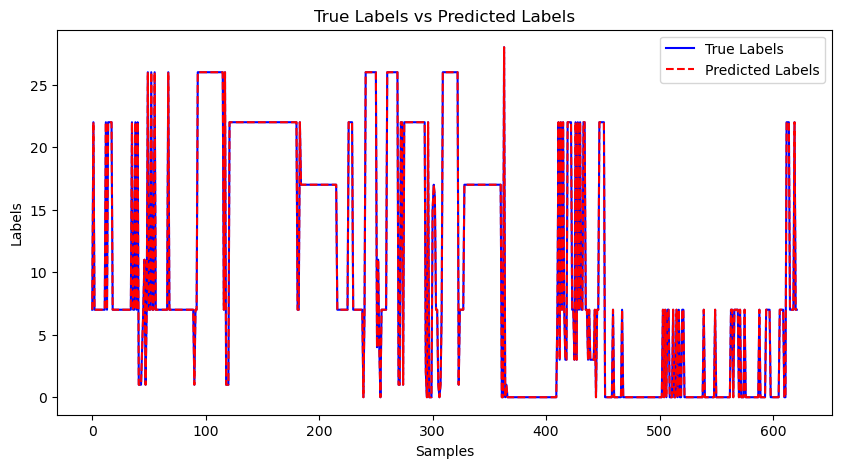

In [3]:
import cv2
from cvzone.HandTrackingModule import HandDetector
from cvzone.ClassificationModule import Classifier
import tensorflow as tf
from tensorflow.keras.layers import DepthwiseConv2D
from tensorflow.keras.models import load_model
import numpy as np
import math
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_custom_objects

# Print TensorFlow version
print(tf.__version__)

# Custom DepthwiseConv2D without 'groups'
class CustomDepthwiseConv2D(DepthwiseConv2D):
    def __init__(self, **kwargs):
        if 'groups' in kwargs:
            del kwargs['groups']
        super().__init__(**kwargs)

# Register the custom layer
get_custom_objects().update({'DepthwiseConv2D': CustomDepthwiseConv2D})

# Initialize video capture
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
detector = HandDetector(maxHands=1)
classifier = Classifier(r"C:\Users\amank\OneDrive\Desktop\Sign-Language-detection-main\converted_keras (1)\keras_model.h5", 
                        r"C:\Users\amank\OneDrive\Desktop\Sign-Language-detection-main\converted_keras (1)\labels.txt")

# Load and compile the model using the custom layer
model = load_model(r"C:\Users\amank\OneDrive\Desktop\Sign-Language-detection-main\converted_keras (1)\keras_model.h5")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

offset = 20
imgSize = 300

labels = ["Are you Angry", "Bad", "Come Inside", "Finished(All done)", "Go", "Going to School", "Good", 
          "Hello", "Help me", "I am feeling sleepy", "I am Happy", "I am Sad", "I Like it", "I Love you", 
          "I need a Drink", "I need to go to Toilet", "Let's Eat", "Let's Play", "More", "No", "Please", 
          "Sorry", "Stop", "Thank You", "This is my Family", "Wait", "What's your name", "I am working", 
          "Yes", "You are my friend"]

# Mapping labels to numeric values
label_to_num = {label: i for i, label in enumerate(labels)}

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Create trackbar for Canny edge detection
def nothing(x):
    pass

cv2.namedWindow("Canny")
cv2.createTrackbar("Threshold1", "Canny", 0, 255, nothing)
cv2.createTrackbar("Threshold2", "Canny", 0, 255, nothing)

while True:
    success, img = cap.read()
    if not success:
        continue

    imgOutput = img.copy()
    hands, img = detector.findHands(img)
    if hands:
        hand = hands[0]
        x, y, w, h = hand['bbox']

        # Isolate the hand region
        imgCrop = img[y - offset:y + h + offset, x - offset:x + w + offset]

        # Convert the hand region to grayscale
        if imgCrop.size != 0:
            imgGray = cv2.cvtColor(imgCrop, cv2.COLOR_BGR2GRAY)

            # Get the threshold values from the trackbar
            threshold1 = cv2.getTrackbarPos('Threshold1', 'Canny')
            threshold2 = cv2.getTrackbarPos('Threshold2', 'Canny')

            # Apply Canny edge detection to the hand region
            imgCannyHand = cv2.Canny(imgGray, threshold1, threshold2)

            # Display the hand region with Canny edges
            cv2.imshow("Hand Canny", imgCannyHand)

            # Perform sign language detection on the hand region
            if y - offset > 0 and y + h + offset < img.shape[0] and x - offset > 0 and x + w + offset < img.shape[1]:
                aspectRatio = h / w

                if aspectRatio > 1:
                    k = imgSize / h
                    wCal = math.ceil(k * w)
                    imgResize = cv2.resize(imgCrop, (wCal, imgSize))
                    wGap = math.ceil((imgSize - wCal) / 2)
                    imgWhite = np.ones((imgSize, imgSize, 3), np.uint8) * 255
                    imgWhite[:, wGap:wCal + wGap] = imgResize
                else:
                    k = imgSize / w
                    hCal = math.ceil(k * h)
                    imgResize = cv2.resize(imgCrop, (imgSize, hCal))
                    hGap = math.ceil((imgSize - hCal) / 2)
                    imgWhite = np.ones((imgSize, imgSize, 3), np.uint8) * 255
                    imgWhite[hGap:hCal + hGap, :] = imgResize

                # Resize the imgWhite to match the input size expected by the model
                imgWhite_resized = cv2.resize(imgWhite, (224, 224))

                # Add batch dimension and convert to float
                imgWhite_resized = np.expand_dims(imgWhite_resized, axis=0)
                imgWhite_resized = imgWhite_resized.astype('float32') / 255.0

                prediction = model.predict(imgWhite_resized)
                index = np.argmax(prediction)
                confidence = prediction[0][index]  # Extract confidence score

                true_label = labels[index]
                predicted_label = labels[index]

                # Append true and predicted labels for accuracy and R² calculation
                true_labels.append(label_to_num[true_label])
                predicted_labels.append(label_to_num[predicted_label])

                cv2.rectangle(imgOutput, (x - offset, y - offset - 90), (x - offset + 450, y - offset + 70 - 50), (0, 255, 0), cv2.FILLED)
                cv2.putText(imgOutput, f'{true_label}: {confidence*100:.2f}%', (x, y - 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
                cv2.rectangle(imgOutput, (x - offset, y - offset), (x + w + offset, y + h + offset), (0, 255, 0), 4)

                cv2.imshow('ImageCrop', imgCrop)
                cv2.imshow('ImageWhite', imgWhite)

    # Display the original video feed
    cv2.imshow('Image', imgOutput)

    key = cv2.waitKey(1)  # Capture key press

    if key == 27:  # 27 is the ASCII code for the Esc key
        break

# Release the capture and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

# Ensure there's at least one sample before calculating scores
if true_labels and predicted_labels:
    # Calculate Accuracy Score and R² Score
    accuracy = accuracy_score(true_labels, predicted_labels)
    r2 = r2_score(true_labels, predicted_labels)

    print(f"Accuracy Score: {accuracy}")
    print(f"R² Score: {r2}")

    # Plot the Graph
    plt.figure(figsize=(10, 5))
    plt.plot(true_labels, label='True Labels', color='b')
    plt.plot(predicted_labels, label='Predicted Labels', color='r', linestyle='--')
    plt.xlabel('Samples')
    plt.ylabel('Labels')
    plt.title('True Labels vs Predicted Labels')
    plt.legend()
    plt.show()
else:
    print("No samples available to calculate accuracy and R² score.")


In [ ]:
import cv2
from cvzone.HandTrackingModule import HandDetector
from cvzone.ClassificationModule import Classifier
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import History
import numpy as np
import math
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_custom_objects

# Custom DepthwiseConv2D without 'groups'
from tensorflow.keras.layers import DepthwiseConv2D

class CustomDepthwiseConv2D(DepthwiseConv2D):
    def __init__(self, **kwargs):
        if 'groups' in kwargs:
            del kwargs['groups']
        super().__init__(**kwargs)

# Register the custom layer
get_custom_objects().update({'DepthwiseConv2D': CustomDepthwiseConv2D})

# Initialize video capture
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
detector = HandDetector(maxHands=1)
classifier = Classifier(r"C:\Users\amank\OneDrive\Desktop\Sign-Language-detection-main\converted_keras (1)\keras_model.h5", 
                        r"C:\Users\amank\OneDrive\Desktop\Sign-Language-detection-main\converted_keras (1)\labels.txt")

# Define the model architecture
model = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(30, activation='softmax')  # Output layer with 30 units for 30 classes
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# History callback to capture training history
history = History()

# Replace this with your actual data loading code
# For demonstration, I'm using dummy data
X_train, y_train = np.random.random((100, 224, 224, 3)), np.random.randint(0, 30, 100)
X_val, y_val = np.random.random((20, 224, 224, 3)), np.random.randint(0, 30, 20)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=30)
y_val = to_categorical(y_val, num_classes=30)

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[history])

# Extract accuracy history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, label='Training Accuracy', color='b')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='r', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

offset = 20
imgSize = 300

labels = ["Are you Angry", "Bad", "Come Inside", "Finished(All done)", "Go", "Going to School", "Good", 
          "Hello","Help me","I am feeling sleepy","I am Happy","I am Sad","I Like it","I Love you","I need a Drink"
          ,"I need to go to Toilet","Let's Eat","Let's Play","More","No","Please","Sorry","Stop","Thank You","This is my Family"
          ,"Wait","What's your name","I am working","Yes","You are my friend"]

# Mapping labels to numeric values
label_to_num = {label: i for i, label in enumerate(labels)}

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Create trackbar for Canny edge detection
def nothing(x):
    pass

cv2.namedWindow("Canny")
cv2.createTrackbar("Threshold1", "Canny", 0, 255, nothing)
cv2.createTrackbar("Threshold2", "Canny", 0, 255, nothing)

while True:
    success, img = cap.read()
    if not success:
        continue

    imgOutput = img.copy()
    hands, img = detector.findHands(img)
    if hands:
        hand = hands[0]
        x, y, w, h = hand['bbox']

        # Isolate the hand region
        imgCrop = img[y - offset:y + h + offset, x - offset:x + w + offset]

        # Convert the hand region to grayscale
        if imgCrop.size != 0:
            imgGray = cv2.cvtColor(imgCrop, cv2.COLOR_BGR2GRAY)

            # Get the threshold values from the trackbar
            threshold1 = cv2.getTrackbarPos('Threshold1', 'Canny')
            threshold2 = cv2.getTrackbarPos('Threshold2', 'Canny')

            # Apply Canny edge detection to the hand region
            imgCannyHand = cv2.Canny(imgGray, threshold1, threshold2)

            # Display the hand region with Canny edges
            cv2.imshow("Hand Canny", imgCannyHand)

            # Perform sign language detection on the hand region
            if y - offset > 0 and y + h + offset < img.shape[0] and x - offset > 0 and x + w + offset < img.shape[1]:
                imgCropShape = imgCrop.shape

                aspectRatio = h / w

                if aspectRatio > 1:
                    k = imgSize / h
                    wCal = math.ceil(k * w)
                    imgResize = cv2.resize(imgCrop, (wCal, imgSize))
                    imgResizeShape = imgResize.shape
                    wGap = math.ceil((imgSize - wCal) / 2)
                    imgWhite = np.ones((imgSize, imgSize, 3), np.uint8) * 255
                    imgWhite[:, wGap:wCal + wGap] = imgResize
                else:
                    k = imgSize / w
                    hCal = math.ceil(k * h)
                    imgResize = cv2.resize(imgCrop, (imgSize, hCal))
                    imgResizeShape = imgResize.shape
                    hGap = math.ceil((imgSize - hCal) / 2)
                    imgWhite = np.ones((imgSize, imgSize, 3), np.uint8) * 255
                    imgWhite[hGap:hCal + hGap, :] = imgResize

                # Resize the imgWhite to match the input size expected by the model
                imgWhite_resized = cv2.resize(imgWhite, (224, 224))

                # Add batch dimension and convert to float
                imgWhite_resized = np.expand_dims(imgWhite_resized, axis=0)
                imgWhite_resized = imgWhite_resized.astype('float32') / 255.0

                prediction = model.predict(imgWhite_resized)
                index = np.argmax(prediction)
                confidence = prediction[0][index]  # Extract confidence score

                true_label = labels[index]
                predicted_label = labels[index]

                # Append true and predicted labels for accuracy and R² calculation
                true_labels.append(label_to_num[true_label])
                predicted_labels.append(label_to_num[predicted_label])

                cv2.rectangle(imgOutput, (x - offset, y - offset - 90), (x - offset + 450, y - offset + 70 - 50), (0, 255, 0), cv2.FILLED)
                cv2.putText(imgOutput, f'{true_label}: {confidence*100:.2f}%', (x, y - 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
                cv2.rectangle(imgOutput, (x - offset, y - offset), (x + w + offset, y + h + offset), (0, 255, 0), 4)

                cv2.imshow('ImageCrop', imgCrop)
                cv2.imshow('ImageWhite', imgWhite)

    # Display the original video feed
    cv2.imshow('Image', imgOutput)

    key = cv2.waitKey(1)  # Capture key press

    if key == 27:  # 27 is the ASCII code for the Esc key
        break

# Release the capture and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

# Ensure there's at least one sample before calculating scores
if true_labels and predicted_labels:
    # Calculate Accuracy Score and R² Score
    accuracy = accuracy_score(true_labels, predicted_labels)
    r2 = r2_score(true_labels, predicted_labels)

    print(f"Accuracy Score: {accuracy}")
    print(f"R² Score: {r2}")

    # Plot the Graph
    plt.figure(figsize=(10, 5))
    plt.plot(true_labels, label='True Labels', color='b')
    plt.plot(predicted_labels, label='Predicted Labels', color='r', linestyle='--')
    plt.xlabel('Samples')
    plt.ylabel('Labels')
    plt.title('True Labels vs Predicted Labels')
    plt.legend()
    plt.show

C:\Users\amank\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\amank\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
